In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential 
from tensorflow.keras import layers
from keras.layers import Input, Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
# dataset paths
csv_path_train = 'Datasets\sign_mnist_train\sign_mnist_train.csv'
csv_path_test = 'Datasets\sign_mnist_test\sign_mnist_test.csv'

In [3]:
# loading data
train_df = pd.read_csv(csv_path_train)
test_df = pd.read_csv(csv_path_test)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 43.0 MB


In [6]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [7]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


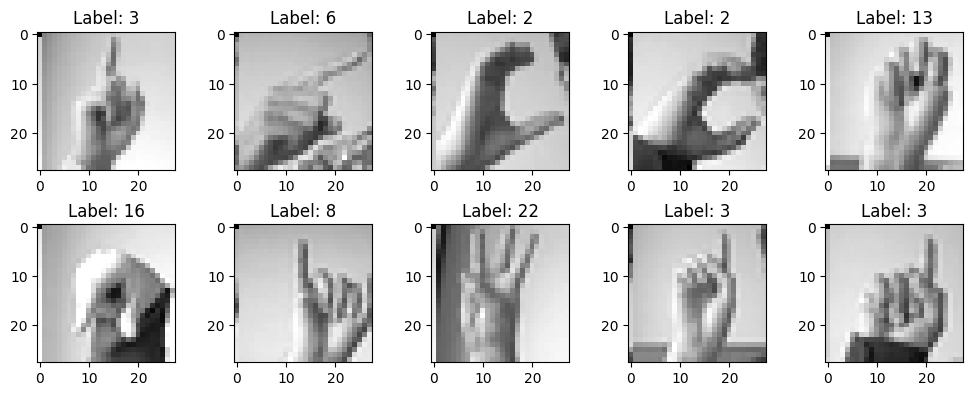

In [8]:
# plotting the data
pixels = train_df.iloc[:, :-1].values
labels = train_df['label'].values

num_rows = 2
num_cols = 5


fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 4))

num_images_to_visualize = 10
for i in range(num_images_to_visualize):
    row = i // num_cols
    col = i % num_cols
    image = pixels[i].reshape(28, 28)
    
    label = labels[i]
    axes[row, col].set_title(f"Label: {label}")
    
    axes[row, col].imshow(image, cmap='gray')

for i in range(num_images_to_visualize, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

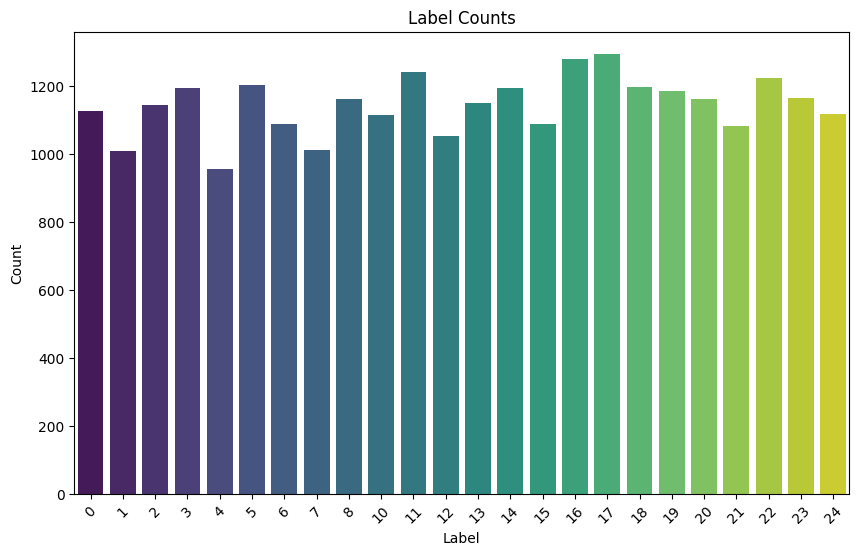

In [9]:
label_counts = train_df['label'].value_counts().sort_index()
cmap = sns.color_palette("viridis", n_colors=len(label_counts))

# Create a bar plot with gradient colors using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette=cmap, legend=False)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Counts')
plt.xticks(rotation=45)  # Optionally, rotate the x-axis labels for better readability
plt.show()

In [23]:
label_counts.values

array([1126, 1010, 1144, 1196,  957, 1204, 1090, 1013, 1162, 1114, 1241,
       1055, 1151, 1196, 1088, 1279, 1294, 1199, 1186, 1161, 1082, 1225,
       1164, 1118], dtype=int64)

In [28]:
np.mean(label_counts.values)

1143.9583333333333

From this we can see that we have suuficent lables in each class which helps in training

In [10]:
y_train = train_df['label']
y_test = test_df['label']
x_train= train_df.iloc[:, :-1].values
x_test = test_df.iloc[:, :-1].values

In [11]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [12]:
x_train.shape

(27455, 784)

In [13]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

In [14]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [15]:
x_train.shape

(27455, 28, 28, 1)

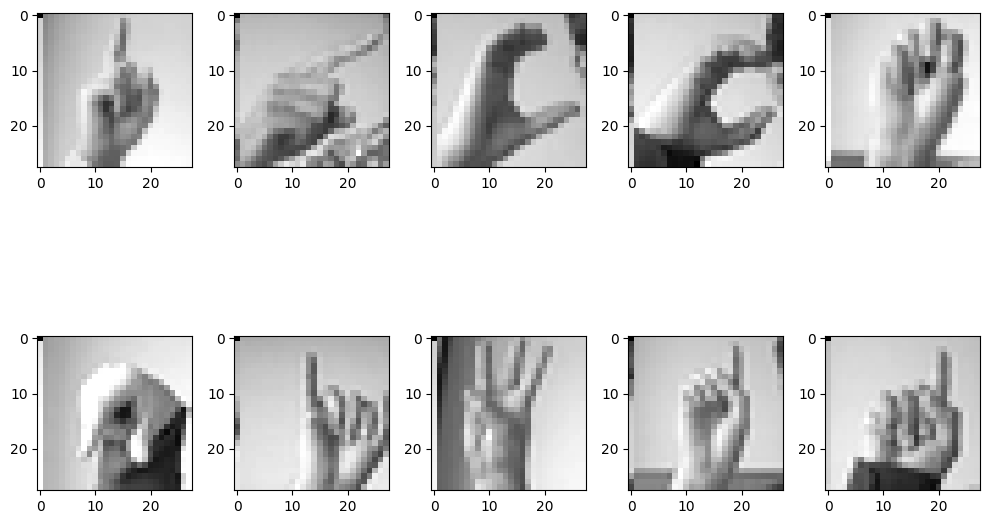

In [16]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()    

In [17]:
datagen = ImageDataGenerator( 
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [20]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))

In [35]:
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 75)        750       
                                                                 
 batch_normalization_8 (Batc  (None, 28, 28, 75)       300       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 75)       0         
 2D)                                                             
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 7, 7, 75)         0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 3675)              0         
                                                      

 dense_6 (Dense)             (None, 512)               1882112   
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 24)                12312     
                                                                 
Total params: 1,895,474
Trainable params: 1,895,324
Non-trainable params: 150
_________________________________________________________________


In [22]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 10 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/10
215/215 [==============================] - 13s 41ms/step - loss: 1.0806 - accuracy: 0.6571 - val_loss: 3.2782 - val_accuracy: 0.1592 - lr: 0.0010
Epoch 2/10
215/215 [==============================] - 7s 33ms/step - loss: 0.2225 - accuracy: 0.9261 - val_loss: 1.0103 - val_accuracy: 0.6513 - lr: 0.0010
Epoch 3/10
215/215 [==============================] - 7s 34ms/step - loss: 0.1078 - accuracy: 0.9654 - val_loss: 0.3000 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 4/10
215/215 [==============================] - 7s 34ms/step - loss: 0.0717 - accuracy: 0.9772 - val_loss: 0.0796 - val_accuracy: 0.9695 - lr: 0.0010
Epoch 5/10
215/215 [==============================] - 7s 34ms/step - loss: 0.0520 - accuracy: 0.9828 - val_loss: 0.0218 - val_accuracy: 0.9926 - lr: 0.0010
Epoch 6/10
215/215 [==============================] - 7s 34ms/step - loss: 0.0394 - accuracy: 0.9878 - val_loss: 0.0616 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 7/10
215/215 [==============================] - ETA: 0s -